# Source finding demo

## 1. Initialisation

### imports:

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from scipy.special import erf
from scipy.special import erfinv
from scipy.spatial import ConvexHull
from astropy.io import fits
from time import time as time

from numba import njit
from photutils import segmentation as segm
import scipy as sc
from scipy import stats

*TODO*: Properly support repeated values (infinite density)

## 2. Read data

### select one dataset:

In [2]:
dataset = 23

In [3]:
plots = False

In [4]:
#plots = True

1D spectra

2D images:

In [5]:
if dataset == 20:
    object_name = '2D Gaussian noise'
    data = np.random.normal(size=(1000, 1000)) * 42 + 666

In [6]:
if dataset == 21:
    object_name = 'CIG 335'
    hdu = fits.open('data/CIG_335.fits')
    data = hdu[0].data[3000:4000, 1500:2500].astype(np.float32)

In [7]:
if dataset == 22:
    object_name = 'NGC2420'
    hdu = fits.open('data/uamA_0033.fits')
    data = hdu[0].data.astype(np.float32)

In [8]:
if dataset == 23:
    object_name = 'HGC 44 slice'
    hdu = fits.open('data/hcg44_cube_R.fits')
    data = hdu[0].data[69].astype(np.float32) # to make sure it's converted to float
    #data = hdu[0].data[:, 270, :]*1.
    #data = hdu[0].data[:, 170, :]*1.
    #data = hdu[0].data[99]*1.

3D datacubes:

In [9]:
if dataset == 30:
    object_name = '3D Gaussian noise'
    data = np.random.normal(size=(200, 200, 200)) * 42

In [10]:
if dataset == 23:
    object_name = 'HGC 44 slice'
    hdu = fits.open('data/hcg44_cube_R.fits')
    data = hdu[0].data[69].astype(np.float32) # to make sure it's converted to float
    #data = hdu[0].data[:, 270, :]*1.
    #data = hdu[0].data[:, 170, :]*1.
    #data = hdu[0].data[99]*1.

In [11]:
if dataset == 31:
    object_name = 'HGC 44'
    hdu = fits.open('data/hcg44_cube_R.fits')
    data = hdu[0].data[:, 150:350, 350:650].astype(np.float32)

In [12]:
if dataset == 32:
    object_name = 'Synthetic WSRT cube'
    hdu = fits.open('data/sofiawsrtcube.fits')
    data = hdu[0].data.astype(np.float32)  # to make sure it's converted to float


## 3. Noise and background

### estimate noise:

In [13]:
strides = np.array(data.strides)//data.itemsize
data_dimensionality = strides.size

x = data.ravel()
noise = data.flatten() *2*data_dimensionality

for stride in strides:
    noise[:-stride] -= x[stride:]
    noise[stride:] -= x[:-stride]

noise /= 2*data_dimensionality
noise_percentiles = np.nanpercentile(noise, np.arange(101))
noise_std = (noise_percentiles[84] - noise_percentiles[16]) / 2
sigma_noise = noise_std / np.sqrt(1 + 1/2/data_dimensionality)

noise.shape = data.shape

### estimate background:

In [14]:
argsorted_data = np.argsort(data.ravel())

In [15]:
argsorted_data = argsorted_data[np.isfinite(data.ravel()[argsorted_data])]
n_valid = argsorted_data.size
print(f'{n_valid} finite measurements')

490000 finite measurements


In [16]:
x = sorted_data = data.ravel()[argsorted_data]
noise_sorted_by_data = noise.ravel()[argsorted_data]
n = np.arange(n_valid) + 1
sum_noise = np.nancumsum(noise_sorted_by_data)
sum_noise2 = np.nancumsum(noise_sorted_by_data**2)
n1 = np.searchsorted(sorted_data, x-np.sqrt(sum_noise2/n), side='right')
n2 = np.searchsorted(sorted_data, x+np.sqrt(sum_noise2/n), side='left')-1
mean_noise = (sum_noise[n2] - sum_noise[n1]) / (n2 - n1)
mean_noise2 = (sum_noise2[n2] - sum_noise2[n1]) / (n2 - n1)
mean_x = np.cumsum(x) / n
mean_x2 = np.cumsum(x**2) / n
mean_x2 = mean_x2 + x**2 - 2*x*mean_x
mean_x = x-mean_x
'''
condition = (x < np.nanmean(data))
condition &= (mean_x2 > (np.pi/2)*mean_x**2)
condition &= (mean_x2 > sigma_noise**2)
n0 = np.max(n[condition])
#n0 = np.max(n[(mean_x2 > (np.pi/2)*mean_x**2) & (mean_x2 > sigma_noise**2) & (x < np.nanmean(data))])
'''
n0 = n[mean_noise > 0][0] - 1
background = (x[n0]+x[n0-1])/2
background_variance = (mean_x2[n0] + (np.pi/2)*mean_x[n0]**2)/2
background_std = np.sqrt(background_variance)


/tmp/ipykernel_11187/1895581620.py:8: RuntimeWarning: invalid value encountered in true_divide
  mean_noise = (sum_noise[n2] - sum_noise[n1]) / (n2 - n1)
/tmp/ipykernel_11187/1895581620.py:9: RuntimeWarning: invalid value encountered in true_divide
  mean_noise2 = (sum_noise2[n2] - sum_noise2[n1]) / (n2 - n1)


### background and noise tests:

In [17]:
print(f'DATA: shape = {data.shape}, {strides}')
print(f'      value      = {np.nanmean(data):.3g} +- {np.nanstd(data):.3g}')
print(f'      background = {background:.3g} +- {background_std:.3g}')
print(f'NOISE: percentiles = {noise_percentiles[16]:.3g}, {noise_percentiles[50]:.3g}, {noise_percentiles[84]:.3g}')
print(f'       std         = {np.nanstd(noise):.3g} (compared to {sigma_noise:.3g})')

DATA: shape = (700, 700), [700   1]
      value      = 1.97e-06 +- 0.000229
      background = -6.3e-07 +- 0.00022
NOISE: percentiles = -2.67e-05, -4.7e-08, 2.66e-05
       std         = 2.75e-05 (compared to 2.38e-05)


In [18]:
if plots:
    plt.close('background')
    fig = plt.figure('background', figsize=(12, 5))
    axes = fig.subplots(nrows=2, ncols=2, squeeze=False,
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0}
                       )

    x = sorted_data
    n = np.arange(x.size) + 1
    
    ax = axes[0, 0]
    ax.set_ylabel('cumulative fraction')
    ax.set_yscale('log')
    f_background = min(2*n0/data.size, 1)
    ax.plot(x, n/n_valid, 'k-', label=f'data ({100*(1-f_background):.2f}% source)')
    cumulative_normal = (1 + sc.special.erf((x-background)/np.sqrt(2*background_variance))) / 2
    ax.plot(x, f_background*cumulative_normal, 'k:', label=f'background ({100*f_background:.2f}%)')
    ax.legend()

    ax = axes[1, 0]
    ax.set_ylabel('variance')
    ax.set_yscale('log')
    ax.plot(x, (np.pi/2)*mean_x**2, 'k--', label=r'$\frac{\pi}{2}$ (data-<data>)$^2$')
    ax.plot(x, mean_x2, 'k-', label='<(data-<data>)$^2$>')
    #ax.plot(x, sum_noise2/n, 'r-', label=r'$<noise^2>$')
    #ax.plot(x, (sum_noise/n)**2, 'r--', label=r'$<noise>^2$')
    
    ax.plot(x, mean_noise, 'r:')
    ax.plot(x, mean_noise2, 'r--')
#    ax.fill_between(x, x-np.sqrt(sum_noise2/n), x+np.sqrt(sum_noise2/n), 'r', alpha=.2)
    ax.plot(background, background_variance, 'ko')
    ax.legend()

    x = np.sort(noise.flatten())
    n = np.arange(x.size) + 1

    ax = axes[0, 1]
    ax.plot(x, n/n_valid, 'k-', label=f'noise ({100*(1-f_background):.2f}% source)')
    cumulative_normal = (1 + sc.special.erf(x/np.sqrt(2*noise_std**2))) / 2
    ax.plot(x, f_background*cumulative_normal, 'k:', label=f'noise_std = {noise_std:.3g}')
    cumulative_normal = (1 + sc.special.erf(x/np.sqrt(2*background_variance))) / 2
    ax.plot(x, 1e-3*f_background*cumulative_normal, 'k--', label=f'background_std = {background_std:.3g}')
    ax.axvspan(-sigma_noise, sigma_noise, color='b', alpha=.1)
    ax.axvspan(-background_std, background_std, color='r', alpha=.1)
    ax.legend()

    ax = axes[1, 1]
    #ax.set_ylabel('variance')
    ax.set_yscale('log')
    #ax.plot(x, (np.pi/2)*mean_noise**2, 'k--', label=r'$\frac{\pi}{2}$ (noise-<noise>)$^2$')
    #ax.plot(x, mean_noise2, 'k-', label='<(noise-<noise>)$^2$>')
    ax.axhline(background_variance, c='k', ls='--', label=f'background_std={background_std:.3g}')
    ax.axhline(sigma_noise**2, c='k', ls=':', label=f'sigma_noise={sigma_noise:.3g}')
    ax.axvspan(-sigma_noise, sigma_noise, color='b', alpha=.1)
    ax.axvspan(-background_std, background_std, color='r', alpha=.1)
    ax.legend()
    
    #axes[-1, 0].set_xscale('log')
    axes[-1, 0].set_xlim(max(sorted_data[0], background-10*background_std), background+10*background_std)
    axes[-1, 0].set_xlabel('data')
    axes[-1, 1].set_xlabel('noise')
    
    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()

In [19]:
if plots:
    plt.close('noise')
    fig = plt.figure('noise', figsize=(12, 6))
    axes = fig.subplots(nrows=2, ncols=2, squeeze=False,
                        sharex=False, sharey=False,
                        gridspec_kw={'hspace': 0, 'wspace': 0}
                       )


    x = data.ravel() # - background
    f = data.ravel() - noise.ravel()
    
    ax = axes[0, 0]
    ax.set_ylabel('data value')
    h2d = ax.hist2d(noise.ravel(), x,
                    bins=[np.linspace(-5*sigma_noise, 5*sigma_noise, 101),
                          np.linspace(background-15*sigma_noise, background+15*sigma_noise, 101)],
                   cmap='nipy_spectral')

    #ax[0, 0].scatter((x-f)[1000:-1000], x[1000:-1000], c='y', s=1, alpha=.01)
    #bg = np.median(data)
    ax.plot(noise_percentiles, background+noise_percentiles/(1+1/2/data_dimensionality), 'w--')
    ax.plot(noise_percentiles-2*noise_std, background+noise_percentiles/(1+1/2/data_dimensionality), 'w:')
    ax.plot(noise_percentiles+2*noise_std, background+noise_percentiles/(1+1/2/data_dimensionality), 'w:')

    ax = axes[0, 1]
    ax.axis('off')
    p2d_noise = np.cumsum(h2d[0], axis=1)  # summed over data
    n_noise = p2d_noise[:, -1].copy()
    p2d_noise /= n_noise[:, np.newaxis]
    im = ax.imshow(p2d_noise.T, origin='lower', cmap='seismic')
    i = np.arange(p2d_noise.shape[0])
    ax.plot(i, i/(1+1/2/data_dimensionality), 'y--')
    cb = fig.colorbar(im, ax=ax)
    cb.ax.set_ylabel('data cumulaive traction')

    ax = axes[1, 1]
    ax.axis('off')
    p2d_data = np.cumsum(h2d[0], axis=0)  # summed over noise
    n_data = p2d_data[-1, :].copy()
    p2d_data /= n_data[np.newaxis, :]
    im = ax.imshow(p2d_data.T, origin='lower', cmap='seismic')
    ax.plot(i, i, 'y--')
    cb = fig.colorbar(im, ax=ax)
    cb.ax.set_ylabel('noise cumulative fraction')


    ax = axes[1, 0]
    ax.set_ylabel('probability distribution')
    xbins = (h2d[1][:-1]+h2d[1][1:])/2
    dxbins = h2d[1][1:]-h2d[1][:-1]
    ax.plot(xbins, n_noise/dxbins/np.nansum(n_noise), 'k+')
    ax.plot(xbins, np.exp(-.5*(xbins/background_std)**2)/np.sqrt(2*np.pi)/background_std, 'k:', label=f'background ({background_std:.3g})')
    ax.plot(xbins, np.exp(-.5*(xbins/noise_std)**2)/np.sqrt(2*np.pi)/noise_std, 'k--', label=f'noise ({noise_std:.3g})')
    ax.legend()
    
    axes[-1, 0].set_xlabel('estimated noise')
    axes[-1, 0].set_xlim(-5*sigma_noise, 5*sigma_noise)
    #ax[-1, 0].set_xscale('symlog', linthresh=sigma_noise)


    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()

### visual inspection:

In [20]:
data_min = np.nanmin(data)
data_max = np.nanmax(data)
colour_scale = colors.SymLogNorm(vmin=data_min,
                                 linthresh=background + 3*background_std,
                                 vmax=data_max)

In [21]:
if plots and data_dimensionality == 2:
    plt.close('data')
    fig = plt.figure('data', figsize=(8, 6))
    ax = fig.subplots(nrows=2, ncols=3, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )

    ax[0, 0].set_title(f'Input data: {object_name}')
    im = ax[0, 0].imshow(data,
                   interpolation='nearest', origin='lower',
                   cmap='nipy_spectral', norm=colour_scale,
                  )
    cb = fig.colorbar(im, ax=ax[0, 0], orientation='horizontal')
    #cb.ax.axvline(data.threshold, c='w')
    #cb.ax.axvline(2*mode-data.threshold, c='w', ls='--')

    ax[0, 1].set_title('Filtered data')
    im = ax[0, 1].imshow(data - noise,
                   interpolation='nearest', origin='lower',
                   cmap='nipy_spectral', norm=colour_scale,
                  )
    cb = fig.colorbar(im, ax=ax[0, 1], orientation='horizontal')
    #cb.ax.axvline(data.threshold, c='w')
    #cb.ax.axvline(2*mode-data.threshold, c='w', ls='--')
    
    ax[0, 2].set_title('Noise = original - filtered')
    im = ax[0, 2].imshow(noise,
                   interpolation='nearest', origin='lower',
                   #cmap='nipy_spectral', norm=colour_scale,
                   cmap='rainbow', vmin=-3*sigma_noise, vmax=3*sigma_noise,                  )
    cb = fig.colorbar(im, ax=ax[0, 2], orientation='horizontal')
    
    ax[1, 2].set_title('original * filtered')
    im = ax[1, 2].imshow(data*(data-noise) - np.nanmean(data)**2,
                         interpolation='nearest', origin='lower',
                         #cmap='nipy_spectral', norm=colour_scale,
                         cmap='terrain',
                         vmin=-3*background_variance, vmax=3*background_variance,
                         #vmin= -300, vmax = 300
                        )
    cb = fig.colorbar(im, ax=ax[1, 2], orientation='horizontal')
    

    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()

In [22]:
if plots and data_dimensionality == 3:
    plt.close('data')
    fig = plt.figure('data', figsize=(9, 9))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )

    x = data**2
    rms = np.sqrt(np.nanmean(x))
    colour_scale = colors.SymLogNorm(vmin=0, linthresh=2*rms, vmax=10*rms)
    
    ax[0, 0].set_title('Input data (rms value along projected axis)')
    im = ax[0, 0].imshow(np.sqrt(np.nanmean(x, axis=0)),
                         interpolation='nearest', origin='lower', cmap='terrain',
                         norm=colour_scale,
                  )
    ax[0, 0].set_ylabel('declination (celestial "latitude")')

    im = ax[0, 1].imshow(np.sqrt(np.nanmean(x, axis=2)).T,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         norm=colour_scale,
                  )
    ax[0, 1].set_xlabel('frequency channel')
    #ax[0, 1].set_aspect('auto')
    
    im = ax[1, 0].imshow(np.sqrt(np.nanmean(x, axis=1)),
                         interpolation='nearest', origin='lower', cmap='terrain',
                         norm=colour_scale,
                  )
    ax[1, 0].set_xlabel('right ascension (celestial "longitude")')
    ax[1, 0].set_ylabel('frequency channel')
    
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
    fig.set_tight_layout(True)
    
    cb = fig.colorbar(im, ax=ax[1, 1], orientation='horizontal')
    cb.ax.set_title(r'$I_{rms}(x, y) = \sqrt{\frac{1}{N_z} \sum_z I^2(x,y,z)}$')
    ax[1, 1].set_visible(False)
    plt.show()

In [23]:
if plots and data_dimensionality == 3:
    plt.close('noise_cube')
    fig = plt.figure('noise_cube', figsize=(9, 9))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )

    rms = sigma_noise
    colour_scale = colors.SymLogNorm(vmin=0, linthresh=2*rms, vmax=10*rms)
    
    ax[0, 0].set_title('rms noise (Input data - filtered data)')
    im = ax[0, 0].imshow(np.sqrt(np.nanmean(x, axis=0)),
                         interpolation='nearest', origin='lower', cmap='terrain',
                         norm=colour_scale,
                  )
    ax[0, 0].set_ylabel('declination (celestial "latitude")')

    im = ax[0, 1].imshow(np.sqrt(np.nanmean(x, axis=2)).T,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         norm=colour_scale,
                  )
    ax[0, 1].set_xlabel('frequency channel')
    #ax[0, 1].set_aspect('auto')
    
    im = ax[1, 0].imshow(np.sqrt(np.nanmean(x, axis=1)),
                         interpolation='nearest', origin='lower', cmap='terrain',
                         norm=colour_scale,
                  )
    ax[1, 0].set_xlabel('right ascension (celestial "longitude")')
    ax[1, 0].set_ylabel('frequency channel')
    
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
    fig.set_tight_layout(True)
    
    cb = fig.colorbar(im, ax=ax[1, 1], orientation='horizontal')
    cb.ax.set_title(r'$I_{rms}(x, y) = \sqrt{\frac{1}{N_z} \sum_z I^2(x,y,z)}$')
    ax[1, 1].set_visible(False)
    plt.show()

## 3. Hierarchical Overdensity Tree (HOT)

### sorting criterium:

In [24]:
#argsorted_data = np.argsort((data - noise/2).ravel())
#argsorted_data = np.argsort(data.ravel())

### routine definition:

In [25]:
@njit
def hot(data, noise, sorted_strides, argsorted_data, inverted=False, n_pixels=0):
    """Hierarchical Overdenity Tree (HOT)"""

    dimensions = len(data.strides)
    flat_data = data.ravel()
    flat_noise = noise.ravel()
    
    label = np.zeros(data.size, dtype=np.int32)
    n_labels = 0
    
    n_peaks_max = 1 + data.size//2**(dimensions-1)  # maximum number of peaks
    parent = np.zeros(n_peaks_max, dtype=np.int32)
    area = np.zeros(n_peaks_max, dtype=np.int32)
    #sum_value = np.zeros(n_peaks_max, dtype=np.float64)
    #sum_sqare_value = np.zeros(n_peaks_max, dtype=np.float64)
    #sum_noise = np.zeros(n_peaks_max, dtype=np.float64)
    #sum_sqare_noise = np.zeros(n_peaks_max, dtype=np.float64)
    #max_signal_to_noise = np.zeros(n_peaks_max, dtype=np.float32)
    #signal_to_noise_area = np.zeros(n_peaks_max, dtype=np.int32)
    sum_data = np.zeros(n_peaks_max, dtype=np.float64)
    sum_data_data = np.zeros(n_peaks_max, dtype=np.float64)
    sum_data_filter = np.zeros(n_peaks_max, dtype=np.float64)
    sum_filter_filter = np.zeros(n_peaks_max, dtype=np.float64)

    if inverted:
        sorted_index = 0  # minimum
        direction = 1
    else:
        sorted_index = argsorted_data.size-1  # maximum
        direction = -1
    if n_pixels <= 0:
        n_pixels = argsorted_data.size

    pixels_so_far = 0

    while pixels_so_far < n_pixels:
        pixel = argsorted_data[sorted_index]
        #pixel_value = flat_data[pixel]
        #pixel_noise = flat_noise[pixel]
        #print(pixels_so_far, sorted_index, pixel, flat_filtered[pixel], pixel_value, pixel_noise)
        pixel_data = flat_data[pixel]
        pixel_filter = flat_data[pixel] - flat_noise[pixel]
        pixels_so_far += 1
        sorted_index += direction

        neighbour_parents = []
        for dim in range(dimensions):
            stride = sorted_strides[dim]
            remainder = pixel % sorted_strides[dim+1]  # Remember DIRTY HACK 1? ;^D
            if remainder >= stride:  # not at the "left border"
                p = label[pixel-stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)
            if remainder < sorted_strides[dim+1]-stride:  # not at the "right border"
                p = label[pixel+stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)

        neighbour_parents = np.array(neighbour_parents)
        n_parents = neighbour_parents.size
        if n_parents == 0:
            n_labels += 1
            selected_parent = n_labels
            parent[n_labels] = n_labels
        elif n_parents == 1:
            selected_parent = neighbour_parents[0]
        else:
            selected_parent = neighbour_parents[np.argmax(area[neighbour_parents])]
            for p in neighbour_parents:
                if p != selected_parent:
                    sum_data[selected_parent] += sum_data[p]
                    sum_data_data[selected_parent] += sum_data_data[p]
                    area[selected_parent] += area[p]
                    parent[p] = selected_parent

        label[pixel] = selected_parent
        area[selected_parent] += 1

        #sum_value[selected_parent] += pixel_value
        #sum_value[selected_parent] += pixel_value - pixel_noise

        #sum_sqare_value[selected_parent] += pixel_value**2
        #sum_sqare_value[selected_parent] += pixel_value*(pixel_value - pixel_noise)

        #sum_noise[selected_parent] += pixel_noise
        #sum_sqare_noise[selected_parent] += pixel_noise**2
        #n = area[selected_parent]
        #signal_to_noise = (sum_value[selected_parent] - n*smoothed_pixel_value) / np.sqrt(n)
        #if signal_to_noise > max_signal_to_noise[selected_parent]:
        #    max_signal_to_noise[selected_parent] = signal_to_noise
        #    signal_to_noise_area[selected_parent] = n

        sum_data[selected_parent] += pixel_data
        sum_data_data[selected_parent] += pixel_data*pixel_data
        sum_data_filter[selected_parent] += pixel_data*pixel_filter
        sum_filter_filter[selected_parent] += pixel_filter*pixel_filter
        
    n_src = np.count_nonzero(label)
    indep = np.where(parent[1:n_labels+1] == np.arange(1,n_labels+1))
    print(f'{n_labels} overdensities found:',
          f'{n_src} "pixels" ({int(100*n_src/data.size)}%),',
          f'{indep[0].size} independent regions',
         )
    area[0] = data.size-n_src

    #factor = 1 + 1/2/dimensions
    #estimated_noise_variance = sum_sqare_noise[:n_labels+1] / area[:n_labels+1] - (sum_noise[:n_labels+1] / area[:n_labels+1])**2
    #estimated_noise_variance /= factor
    #estimated_noise_variance = 5e-7
    #test_stat = sum_sqare_value[:n_labels+1] / area[:n_labels+1]  - (sum_value[:n_labels+1] / area[:n_labels+1])**2
    #test_stat += estimated_noise_variance / np.sqrt(area[:n_labels+1])
    
    mu = sum_data[:n_labels+1] / area[:n_labels+1]
    dd = sum_data_data[:n_labels+1] / area[:n_labels+1]
    df = sum_data_filter[:n_labels+1] / area[:n_labels+1]
    ff = sum_filter_filter[:n_labels+1] / area[:n_labels+1]
    #test_stat = 4*dimensions*ff - (2*dimensions+3)*dd + (3-2*dimensions)*df
    #test_stat /= 2*dimensions + 1
    
    #test_stat = ff - mu**2 - dd*(1/(2*dimensions) - 1/area[:n_labels+1])
    test_stat = dd - mu**2
    
    #test_stat -= estimated_noise_variance*(1-1/area[:n_labels+1])
    #test_stat *= np.sqrt(area[:n_labels+1])
    #test_stat /= estimated_noise_variance
    
    catalog = (parent[:n_labels+1],
               area[:n_labels+1],
               #sum_value[:n_labels+1],
               #sum_sqare_value[:n_labels+1],
               #np.sqrt((sum_sqare_value[:n_labels+1]/area[:n_labels+1] - (sum_value[:n_labels+1]/area[:n_labels+1])**2) * (area[:n_labels+1] - 1)),
               test_stat,
               #dd/estimated_noise_variance, df/estimated_noise_variance, ff/estimated_noise_variance
               #estimated_noise_variance,
               #max_signal_to_noise[:n_labels+1],
               #signal_to_noise_area[:n_labels+1],
              )

    return label.reshape(data.shape), catalog


### analysis of the normal image:

In [26]:
t0 = time()

label, catalog = hot(data,
                     noise,
                     np.hstack([np.sort(strides), data.size]), # DIRTY HACK when testig particles at the boundary
                     argsorted_data,
                     inverted=False,
                     n_pixels=np.count_nonzero(np.isfinite(data)),
                    )
parent = catalog[0]
area = catalog[1]
test_stat = catalog[2]
print(f'time elapsed: {time()-t0:.3g} s')

9928 overdensities found: 490000 "pixels" (100%), 1 independent regions
time elapsed: 3.52 s


### selectrion criterion:

In [27]:
variance_cut = max(sigma_noise**2, background_variance)
p_value = 1 - stats.chi2.cdf(test_stat*area/variance_cut, df=area-1)
a_pvalue = np.sort(area)
n_pvalue = area.size - np.arange(area.size)


In [28]:
z_Chernoff_max = 1 + np.logspace(-3, 3, 101)
n_Chernoff_max = 1 - 2*np.log(1/test_stat.size)/(z_Chernoff_max-1-np.log(z_Chernoff_max))
z_Chernoff_min = np.logspace(-12, -.01, 101)
n_Chernoff_min = 1 - 2*np.log(1/test_stat.size)/(z_Chernoff_min-1-np.log(z_Chernoff_min))

interp_log_Chernoff_max = np.interp(area, n_Chernoff_max[::-1], np.log10(z_Chernoff_max)[::-1])
#interp_log_Chernoff_min = np.interp(area, n_Chernoff_min, np.log10(test_stat_Chernoff_min))
#test_stat_Chernoff = (np.log10(test_stat*area/(area-1)) - interp_log_Chernoff_max) / np.sqrt(interp_log_Chernoff_max - np.log10(variance_median))

good = area > 1
k = area[good]-1
variance_median = np.nanmedian(test_stat[good]*(k+1)/k/(1-2/9/k)**3)
good = (area > 1) & (test_stat < variance_median*10**interp_log_Chernoff_max)
k = area[good]-1
variance_median = np.nansum(area[good]*test_stat[good]*(k+1)/k)/np.nansum(area[good])
good = (area > 1) & (test_stat < variance_median*10**interp_log_Chernoff_max)
k = area[good]-1
variance_median = np.nansum(area[good]*test_stat[good]*(k+1)/k)/np.nansum(area[good])

reliable_overdensity = (area > 1) & (test_stat > variance_median*10**interp_log_Chernoff_max)


In [29]:
if plots:
    plt.close('test_stat')
    fig = plt.figure('test_stat', figsize=(6, 6))
    ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                      sharex=True, sharey=False,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )

    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)
    
    
    #bins = np.percentile(x, np.linspace(0, 100, int(np.sqrt(x.size)+1)))
    #bins = np.linspace(-5*sigma_noise, 5*sigma_noise, 101)
    #bins = np.linspace(-5, 150, 101)
    bins = np.logspace(-6, 1, 101)*sigma_noise**2

    def plot_area_between(a_min, a_max):
        x = test_stat[(area >= a_min) & (area <= a_max)]
        x = np.sort(x[np.isfinite(x)])
        a = np.sqrt(a_min*a_max)
        estimated_variance = np.mean(x)*a/(a-1)
        ax[0, 0].hist(x, bins=bins, histtype='step', density=True)
        ax[0, 0].plot(bins, stats.chi2.pdf(bins*a/sigma_noise**2, df=a-1)*a/sigma_noise**2, 'k-', alpha=.2)
        ax[1, 0].plot(x, 1-np.arange(x.size)/x.size,
                      label=f'area ={a_min}-{a_max} ({x.size} objects) {estimated_variance/sigma_noise**2:.3g}')
        ax[1, 0].plot(bins, 1-stats.chi2.cdf(bins*a/sigma_noise**2, df=a-1), 'k-', alpha=.2)
        
        
    def plot_area(a):
        x = test_stat[area == a]
        x = np.sort(x[np.isfinite(x)])
        estimated_variance = np.mean(x)*a/(a-1)
        ax[0, 0].hist(x, bins=bins, histtype='step', density=True)
        ax[0, 0].plot(bins, stats.chi2.pdf(bins*a/variance_cut, df=a-1)*a*2/sigma_noise**2, 'k-', alpha=.2)
        ax[1, 0].plot(x, 1-np.arange(x.size)/x.size, label=f'area={a} ({x.size} objects) {estimated_variance/variance_cut:.3g}')
        ax[1, 0].plot(bins, 1-stats.chi2.cdf(bins*a/variance_cut, df=a-1), 'k-', alpha=.2)

    x = test_stat[np.isfinite(test_stat)]
    #ax[0, 0].hist(x, bins=bins, alpha=.2, density=True, label=f'all ({x.size} objects)')
    #ax[0, 0].hist(-x, bins=bins, alpha=.2, density=True, label=f'reflected')

    #dimensions = data_dimensionality
    #t = 4*dimensions*ff - (2*dimensions+3)*dd + (3-2*dimensions)*df
    #t /= 2*dimensions + 1
    #t = ff - dd/2/dimensions
    #ax[0, 0].hist(test_stat, bins=bins, density=True, label=f'test', color='k', histtype='step')
    plot_area(2)
    plot_area(6)
    #plot_area_between(1000, 2000)
    #ax[0, 0].plot(bins, np.exp(-.5*bins**2)/np.sqrt(2*np.pi), 'k--')

    ax[1, 0].legend()
    ax[0, 0].set_xscale('log')
    ax[0, 0].set_yscale('log')
    ax[1, 0].set_yscale('log')
    ax[0, 0].set_ylim(1e-6/sigma_noise**2, 1e3/sigma_noise**2)
    #ax[0, 0].set_ylim(1e-9, 1e5)
    #ax[0, 0].set_xscale('symlog')

    plt.show()

In [30]:
n_reliable = np.count_nonzero(reliable_overdensity)

/tmp/ipykernel_11187/3721660274.py:15: RuntimeWarning: divide by zero encountered in true_divide
  ax[0, 0].scatter(area, test_stat*area/(area-1), s=25, c='c', alpha=.1)
/tmp/ipykernel_11187/3721660274.py:35: RuntimeWarning: invalid value encountered in power
  k_eff = 2/9/(1-np.power(t_median/t_mean, 1/3))


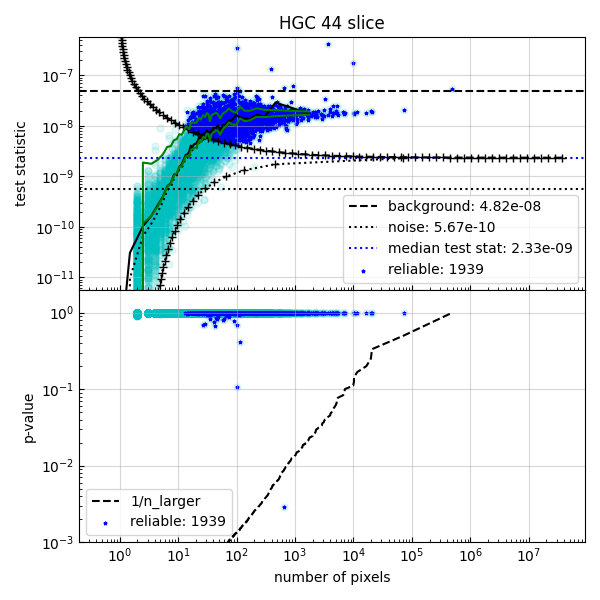

In [31]:
if True:
    plt.close('catalogue_selection')
    fig = plt.figure('catalogue_selection', figsize=(6, 6))
    ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)
    
    ax[0, 0].set_title(object_name)
    ax[0, 0].set_ylabel('test statistic')

    ax[0, 0].scatter(area, test_stat*area/(area-1), s=25, c='c', alpha=.1)
    ax[0, 0].axhline(background_variance, c='k', ls='--', label=f'background: {background_variance:.3g}')
    ax[0, 0].axhline(sigma_noise**2, c='k', ls=':', label=f'noise: {sigma_noise**2:.3g}')
    ax[0, 0].axhline(variance_median, c='b', ls=':', label=f'median test stat: {variance_median:.3g}')
    #ax[0, 0].axhline(Chernoff_variance, c='b', ls='--')
    ax[0, 0].plot(n_Chernoff_max, variance_median*z_Chernoff_max, 'k+--')
    ax[0, 0].plot(n_Chernoff_min, variance_median*z_Chernoff_min, 'k+:')
    #bins_area = np.logspace(0, np.log10(data.size))
    #bins_test_stat = np.linspace(*np.nanpercentile(test_stat, [1, 99]))
    #ax[0, 0].hist2d(area, test_stat, bins=[bins_area, bins_test_stat], cmap='nipy_spectral', vmin=1, vmax=3)

    #ax[0, 0].scatter(area[~possible_overdensity], -test_stat[~possible_overdensity], s=10, c='r', alpha=.25)
    #ax[0, 0].scatter(area[possible_overdensity], test_stat[possible_overdensity], s=1, c='k', label=f'possible: {n_possible}')
    ax[0, 0].scatter(area[reliable_overdensity], test_stat[reliable_overdensity], s=5, c='b', marker='*', label=f'reliable: {n_reliable}')

    n = 100 # int(np.sqrt(area.size))
    a_bins = np.unique(np.sort(area)[::n])
    a_mid = (a_bins[:-1] + a_bins[1:]) / 2
    t_mean = np.array([np.mean(test_stat[(area>a_bins[i]) & (area<=a_bins[i+1])]) for i in range(a_mid.size)])
    t_median = np.array([np.median(test_stat[(area>a_bins[i]) & (area<=a_bins[i+1])]) for i in range(a_mid.size)])
    k_eff = 2/9/(1-np.power(t_median/t_mean, 1/3))
    a_Chernoff_max = np.interp(a_mid, n_Chernoff_max[::-1], np.log10(z_Chernoff_max)[::-1])
    variance_estimate = t_median*a_mid/(a_mid-1)/(1-2/9/(a_mid-1)**3)
    ax[0, 0].plot(a_mid, t_mean, 'k-')
    ax[0, 0].plot(a_mid, t_median, 'k:')
    ax[0, 0].plot(a_mid, variance_estimate, 'g-')
    ax[0, 0].plot(a_mid, variance_estimate*10**a_Chernoff_max, 'g-')

    #ax[0, 0].axvline(area_threshold_min, c='k', ls=':', label=f'area > {area_threshold_min}')
    #ax[0, 0].axhline(test_stat_threshold_min, c='k', ls=':', label=f'test statistic > {test_stat_threshold_min:.2f}')
    #ax[0, 0].axvline(area_threshold_max, c='k', ls='--', label=f'area > {area_threshold_max}')
    #ax[0, 0].axhline(test_stat_threshold_max, c='k', ls='--', label=f'test statistic > {test_stat_threshold_max:.2f}')

    ax[0, 0].set_ylim(1e-2*sigma_noise**2, 1e3*sigma_noise**2)
    #ax[0, 0].set_xlim(.5, 3e3)
    #ax[0, 0].set_ylim(-15, 45)
    #ax[0, 0].set_yscale('symlog')
    ax[0, 0].set_yscale('log')
    ax[0, 0].legend()

    
    ax[1, 0].set_ylabel('p-value')
    ax[1, 0].set_yscale('log')
    #ax[1, 0].set_ylim(.1/test_stat.size)
    ax[1, 0].scatter(area, p_value, s=25, c='c', alpha=.1)
    ax[1, 0].plot(a_pvalue, 1/n_pvalue, 'k--', label='1/n_larger')
    ax[1, 0].scatter(area[reliable_overdensity], p_value[reliable_overdensity], s=5, c='b', marker='*', label=f'reliable: {n_reliable}')
    ax[1, 0].legend()
    ax[1, 0].set_ylim(1e-3, 2)

    '''
    ax[2, 0].scatter(area, test_stat_Chernoff, s=25, c='c', alpha=.1)
    ax[2, 0].scatter(area[reliable_overdensity], test_stat_Chernoff[reliable_overdensity], s=5, c='b', marker='*', label=f'reliable: {n_reliable}')
    ax[2, 0].axhline(np.log10(variance_median/variance_cut), c='b', ls=':')
    ax[2, 0].set_ylim(-2, 2)
    '''
    
    ax[-1, 0].set_xscale('log')
    ax[-1, 0].set_xlabel('number of pixels')

In [32]:
n_Chernoff_max

array([3.68374011e+07, 2.79467843e+07, 2.12022059e+07, 1.60856099e+07,
       1.22040050e+07, 9.25927145e+06, 7.02525779e+06, 5.33040675e+06,
       4.04457540e+06, 3.06903726e+06, 2.32889806e+06, 1.76734241e+06,
       1.34126949e+06, 1.01798227e+06, 7.72676011e+05, 5.86533122e+05,
       4.45277857e+05, 3.38079975e+05, 2.56723043e+05, 1.94973510e+05,
       1.48102098e+05, 1.12520713e+05, 8.55070174e+04, 6.49954765e+04,
       4.94188481e+04, 3.75879321e+04, 2.86003440e+04, 2.17713084e+04,
       1.65811549e+04, 1.26354857e+04, 9.63495639e+03, 7.35234886e+03,
       5.61517680e+03, 4.29248816e+03, 3.28485178e+03, 2.51675966e+03,
       1.93086194e+03, 1.48359228e+03, 1.14184827e+03, 8.80472105e+02,
       6.80338698e+02, 5.26904513e+02, 4.09106074e+02, 3.18523800e+02,
       2.48747193e+02, 1.94892826e+02, 1.53238306e+02, 1.20944264e+02,
       9.58431649e+01, 7.62788428e+01, 6.09845559e+01, 4.89902841e+01,
       3.95522416e+01, 3.20992617e+01, 2.61919999e+01, 2.14918782e+01,
      

In [33]:
#true_overdensity = (area > 30) & (test_stat > 1)
#true_overdensity = possible_overdensity
true_overdensity = reliable_overdensity

## 8. Clean-up

### prune HOT based on selection threshold

In [34]:
original_labels = np.arange(parent.size)
island = (parent == original_labels)
pruned_labels = np.zeros_like(original_labels)
pruned_labels[true_overdensity | ~island] = original_labels[true_overdensity | ~island]

pruned_OK = true_overdensity[pruned_labels]
to_go = np.count_nonzero(~pruned_OK)
while True:
    print(f'{to_go} yet to go')
    pruned_labels[~pruned_OK] = parent[pruned_labels[~pruned_OK]]
    pruned_OK = true_overdensity[pruned_labels]
    still_to_go = np.count_nonzero(~pruned_OK)
    if still_to_go == to_go:
        break
    else:
        to_go = still_to_go
        #break

pruned_labels[~pruned_OK] = 0

7990 yet to go
1825 yet to go
136 yet to go
7 yet to go
1 yet to go


In [35]:
if plots and data_dimensionality == 2:
    segmentation = segm.SegmentationImage(label)
    pruned_segmentation = segm.SegmentationImage(pruned_labels[label])
    plt.close('HOT')
    fig = plt.figure('HOT', figsize=(14, 8))
    fig.set_tight_layout(True)
    ax = fig.subplots(nrows=2, ncols=3, sharex=True, sharey=True)

    ax[0, 0].set_title('Input data')
    im = ax[0, 0].imshow(
        data,
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
        )
    cb = fig.colorbar(im, ax=ax[0, 0])

    ax[0, 1].set_title(f'Initial segmentation\n({parent.size} candidates)')
    im = ax[0, 1].imshow(
        label,
        interpolation='nearest', origin='lower', cmap=segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 1])

    ax[0, 2].set_title('Parent')
    im = ax[0, 2].imshow(
        parent[label],
        interpolation='nearest', origin='lower', cmap=segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 2])

    #ax[1, 0].set_title('Max value')
    #ax[1, 0].set_title('Contrast')
    #ax[1, 0].set_title('Max S/N')
    ax[1, 0].set_title('Test statistic')
    im = ax[1, 0].imshow(
        #max_value[label]-min_value[label],
        #test_stat[label],
        p_value[label],
        interpolation='nearest', origin='lower', cmap='rainbow',
        #norm=colour_scale,
        #vmax=np.nanmax(test_stat_inv[1:])
        #vmax=3,
        #vmin = 0, vmax = test_stat_threshold_max,
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    '''
    ax[1, 1].set_title('S/N threshold')
    im = ax[1, 1].imshow(
        #saddle_value[label],
        signal_to_noise_threshold[label],
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
        )
    '''
    ax[1, 1].set_title('Pruned segmentation')
    im = ax[1, 1].imshow(
        pruned_segmentation,
        interpolation='nearest', origin='lower', cmap=pruned_segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[1, 1])

    ax[1, 2].set_title('Area')
    im = ax[1, 2].imshow(
        area[label],
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm=colors.LogNorm(),
        )
    cb = fig.colorbar(im, ax=ax[1, 2])


### rename labels and create final catalogues

In [36]:
final_labels = pruned_labels.astype(np.int32)
old_label = np.sort(np.unique(pruned_labels))
new_label = np.zeros_like(parent)
n_final_labels = old_label.size
print(f'{n_final_labels} objects after mode filtering')

for i, lbl in enumerate(old_label):
    new_label[lbl] = i
    final_labels[final_labels == lbl] = i

new_parent = new_label[parent[old_label]]
final_labels = new_label[pruned_labels[label]]

1940 objects after mode filtering


In [37]:
#final_labels[data < signal_to_noise_threshold[label]] = 0

In [38]:
if plots and data_dimensionality == 2:
    if n_reliable > 0:
        final_selection = segm.SegmentationImage(final_labels)
        final_cmap = final_selection.make_cmap(seed=123)
        final_catalog = segm.SourceCatalog(data, final_selection)
        final_catalog.to_table()
    else:
        final_selection = final_labels
        final_cmap = 'viridis'

In [39]:
if plots and data_dimensionality == 2:
    plt.close('segmentation')
    fig = plt.figure('segmentation', figsize=(12, 4))
    ax = fig.subplots(nrows=1, ncols=3, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title(object_name)
    im = ax[0, 0].imshow(
        data,
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm = colour_scale,
        )
    #ax[0, 0].contour(final_labels, levels=[0.5], colors=['k'])
    #ax[0, 0].contour(smoothed_data, levels=[threshold_guess], colors=['w'])
    cb = fig.colorbar(im, ax=ax[0, 0])
    #cb.ax.axhline(mode, c='k', ls=':')
    #cb.ax.axhline(data.threshold, c='w', ls='--')
    #cb.ax.axhline(2*mode-data.threshold, c='w', ls='--')
    #final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 0], color='w')
    #ax[0, 0].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='w', marker='o')
    if n_reliable > 0:
        ax[0, 0].scatter(final_catalog.maxval_xindex, final_catalog.maxval_yindex, s=25, c='w', marker='+')

    '''
    ax[0, 1].set_title('Smoothed data')
    im = ax[0, 1].imshow(
        smoothed_data,
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm = colour_scale,
        )
    ax[0, 1].contour(final_labels, levels=[0.5])
    #ax[0, 1].contour(smoothed_data, levels=[threshold_guess], colors=['w'])
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(smoothed_mode, c='k', ls=':')
    cb.ax.axhline(smoothed_threshold_guess, c='k', ls='--')
    #final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 0], color='k')
    ax[0, 1].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='k', marker='+')
    '''
    ax[0, 1].set_title(f'segmentation ({n_final_labels} objects)')
    im = ax[0, 1].imshow(
        final_selection,
        interpolation='nearest', origin='lower', cmap=final_cmap,
        )
    if n_reliable > 0:
        ax[0, 1].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='w', marker='o')
        ax[0, 1].scatter(final_catalog.maxval_xindex, final_catalog.maxval_yindex, s=25, c='k', marker='+')
        final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 1], color='white')
    cb = fig.colorbar(im, ax=ax[0, 1])

    axis = ax[0, 2]
    axis.set_title('Test statistic')
    im = axis.imshow(
        np.log10(test_stat[label]/variance_cut),
        interpolation='nearest', origin='lower', cmap='rainbow',
        vmin = -3, vmax = 3,
        )
    cb = fig.colorbar(im, ax=axis)

    '''
    axis = ax[0, 3]
    axis.set_title('p_value')
    im = axis.imshow(
        test_stat_Chernoff[label],
        interpolation='nearest', origin='lower', cmap='rainbow',
        #vmin = 0, vmax = test_stat_threshold_max,
        )
    cb = fig.colorbar(im, ax=axis)
    '''


In [40]:
if plots and data_dimensionality == 3:

    mode = 0
    
    max_map = np.nanmax(final_labels, axis=0)
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(10, 10))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      #gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data (max)')
    im = ax[0, 0].imshow(
        np.nanmax(data, axis=0),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colour_scale
    )
    ax[0, 0].contour(max_map, levels=0)
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    #cb.ax.axhline(data.threshold-mode, c='k', ls='--')
    
    ax[0, 1].set_title('Input data (rms)')
    im = ax[0, 1].imshow(
        np.sqrt(np.nanmean((data-mode)**2, axis=0)),
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-mode)),
        #vmin=-delta/100, vmax=3*delta/10,
        #norm = colour_scale,
    )
    ax[0, 1].contour(max_map, levels=0)
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(0, c='k', ls=':')
    #cb.ax.axhline(data.threshold-mode, c='k', ls='--')
    
    ax[1, 0].set_title(f'Final selection map (max)\n({n_final_labels} objects)')
    im = ax[1, 0].imshow(
        max_map,
        interpolation='nearest', origin='lower',
        cmap='rainbow', vmin=1, vmax=n_final_labels-1,
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    ax[1, 1].set_title('<lbl^2> / <lbl>')
    im = ax[1, 1].imshow(
        np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),
        interpolation='nearest', origin='lower',
        cmap='rainbow', vmin=1, vmax=n_final_labels-1,
        )
    cb = fig.colorbar(im, ax=ax[1, 1])


In [41]:
if plots and data_dimensionality == 3:
    x_range = np.round(plt.figure('filtered').get_axes()[0].get_xlim()).astype(int)
    y_range = np.round(plt.figure('filtered').get_axes()[0].get_ylim()).astype(int)
    section = (data[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]-mode)
    section_lables = final_labels[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    norm = (y_range[1] - y_range[0]) * (x_range[1] - x_range[0])
    section_labels = final_labels[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    unique_section_labels = np.unique(section_labels)

    vertical_slit = np.nansum(section_labels**2, axis=2).T / (np.nansum(section_labels, axis=2).T + 1e-300)
    horizontal_slit = np.nansum(section_labels**2, axis=1).T / (np.nansum(section_labels, axis=1).T + 1e-300)

    plt.close('spectrum')
    fig = plt.figure('spectrum', figsize=(8, 8))
    ax = fig.subplots(nrows=5, ncols=1, squeeze=False,
                      sharex=True, sharey=False,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        
    fig.set_tight_layout(True)

    
    ax[0, 0].set_title(f'Mean spectra for x in {x_range}, y in {y_range}\n({unique_section_labels.size} objects)')
    im = ax[0, 0].imshow(
        vertical_slit,
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        )
    ax[0, 0].set_aspect('auto')
    ax[0, 0].set_ylabel(r'$\Delta y$')


    im = ax[1, 0].imshow(np.nanmean(section, axis=2).T,
                   interpolation='nearest', origin='lower', cmap='terrain', norm=colour_scale,
                  )
    ax[1, 0].contour(vertical_slit, levels=0)
    ax[1, 0].set_aspect('auto')
    ax[1, 0].set_ylabel(r'$\Delta y$')


    ax[2, 0].plot(np.nanmean(section, axis=(1, 2)), 'k-', lw=3)
    ax[2, 0].set_ylabel('spectrum')
    for lbl in unique_section_labels:
        mask = np.zeros_like(section)
        mask[section_labels == lbl] = 1
        if lbl == 0:
            ls = ':'
        else:
            ls = '-'
        ax[2, 0].plot(np.nansum(section*mask, axis=(1, 2))/norm, alpha=.5, ls=ls, label=f'{lbl}')
    mean_error = 1/np.sqrt(section.shape[1]*section.shape[2])
    #ax[2, 0].axhline(delta_th*mean_error*bg_std, c='k', ls=':')
    #ax[2, 0].axhline(-delta_th*mean_error*bg_std, c='k', ls=':')
    ax[2, 0].legend()
    
    
    im = ax[3, 0].imshow(np.nanmean(section, axis=1).T,
                   interpolation='nearest', origin='lower', cmap='terrain', norm=colour_scale,
                  )
    ax[3, 0].contour(horizontal_slit, levels=0)
    ax[3, 0].set_aspect('auto')
    ax[3, 0].set_ylabel(r'$\Delta x$')

    ax[4, 0].set_ylabel(r'$\Delta x$')
    im = ax[4, 0].imshow(
        horizontal_slit,
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        )
    ax[4, 0].set_aspect('auto')
    ax[4, 0].set_ylabel(r'$\Delta x$')

    ax[-1, 0].set_xlabel('frequency / wavelength channel')


## Save FITS file

In [42]:
hdu_out = fits.PrimaryHDU(final_labels)
hdu_out.writeto('output/HOT_labels.fits', overwrite=True)
'''
'''


'\n'

In [43]:
if data_dimensionality == 3:
    hdu_out = fits.PrimaryHDU(np.sum(final_labels, axis=0) / (np.count_nonzero(final_labels, axis=0) + 1e-30))
    hdu_out.writeto('output/HOT_mask.fits', overwrite=True)
'''
'''


'\n'